In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 29.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp312-cp312-linux_x86_64.whl size=302021 sha256=90562f179bbddcebe4d79780d35fcc674cae2d7fa977b7a6eb52a0308831f6fa
  Stored in directory: /home/onyxia/.cache/pip/wheels/d8/b7/b5/bc5cfc21613ff88ce55cf4151a9f32e23bd8f4a2c4d51e7c8b
Successfully built peewee


In [15]:
import yfinance as yf
import pandas as pd

# Liste des entreprises cotées avec leurs tickers Yahoo Finance
entreprises = {
    "H&M": "HM-B.ST",
    "Fast Retailing (Uniqlo)": "FRCOY",
    "Boohoo": "BOO.L"
}

# Création d'une liste vide pour stocker les données
data_list = []

# Collecte des données financières pour chaque entreprise
for entreprise, ticker in entreprises.items():
    data = yf.Ticker(ticker)
    hist = data.history(period="5y")  # Données historiques sur 5 ans (Covid)

    # Pour chaque entreprise, on prend les informations de clôture moyenne
    for date, row in hist.iterrows():
        data_list.append({
            'Entreprise': entreprise,
            'Date': date,
            'Ouverture': row['Open'],
            'Haut': row['High'],
            'Bas': row['Low'],
            'Clôture': row['Close'],
            'Volume': row['Volume']
        })

# Créer un DataFrame Pandas à partir de la liste des données collectées
df = pd.DataFrame(data_list)


In [16]:
print(df.head(), df.shape, df['Entreprise'].unique()) #Premières approches de la base de données obtenue avec le scrapping

  Entreprise                       Date   Ouverture        Haut         Bas  \
0        H&M  2019-10-25 00:00:00+02:00  172.171795  172.547180  170.962257   
1        H&M  2019-10-28 00:00:00+01:00  171.462765  173.297927  170.545177   
2        H&M  2019-10-29 00:00:00+01:00  172.213506  172.255217  170.002972   
3        H&M  2019-10-30 00:00:00+01:00  170.586883  170.920544  169.043671   
4        H&M  2019-10-31 00:00:00+01:00  170.169796  170.336626  167.250216   

      Clôture     Volume  
0  171.421051  1586978.0  
1  172.672302  2069996.0  
2  170.712006  2977514.0  
3  170.169800  2105000.0  
4  168.292923  2888484.0   (3782, 7) ['H&M' 'Fast Retailing (Uniqlo)' 'Boohoo']


In [22]:
# Conversion de la colonne "Date" en format datetime avec UTC
df['Date'] = pd.to_datetime(df['Date'], utc=True)

Premières visualisations graphiques

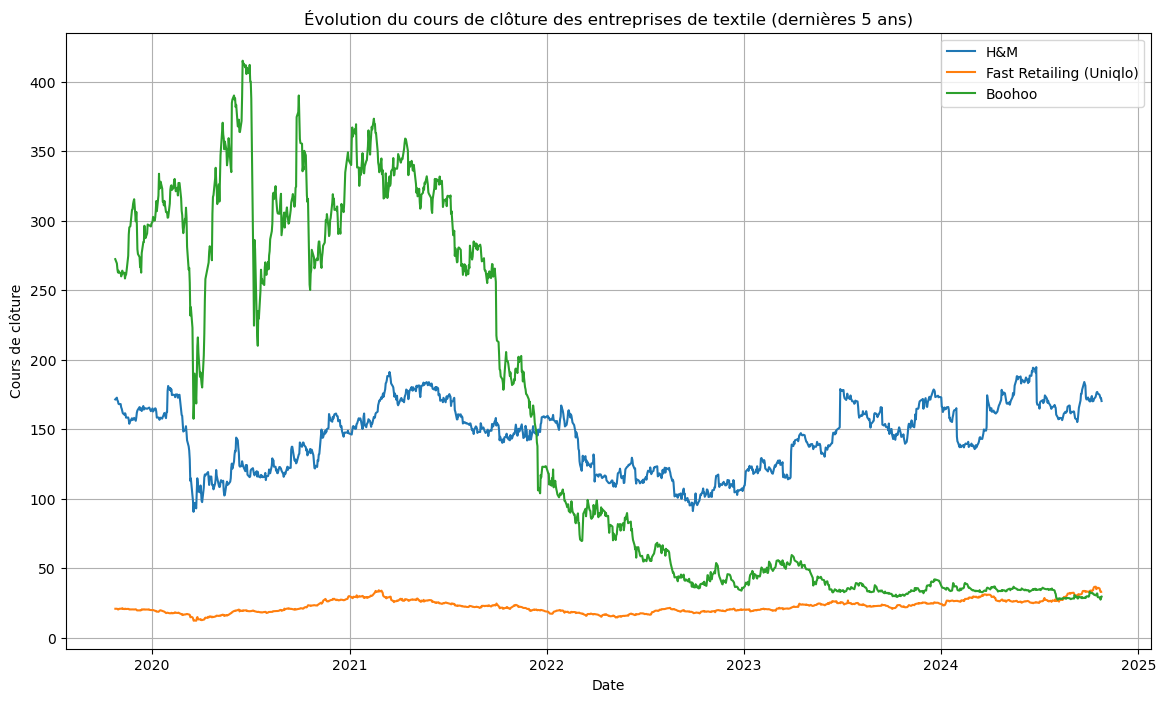

In [25]:
import matplotlib.pyplot as plt

# Filtrer par entreprise et tracer l'évolution du cours de clôture
plt.figure(figsize=(14, 8))
for entreprise in df['Entreprise'].unique():
    df_entreprise = df[df['Entreprise'] == entreprise]
    plt.plot(df_entreprise['Date'], df_entreprise['Clôture'], label=entreprise)

# Ajouter des labels et une légende
plt.title("Évolution du cours de clôture des entreprises de textile (dernières 5 ans)")
plt.xlabel("Date")
plt.ylabel("Cours de clôture")
plt.legend()
plt.grid()
plt.show()

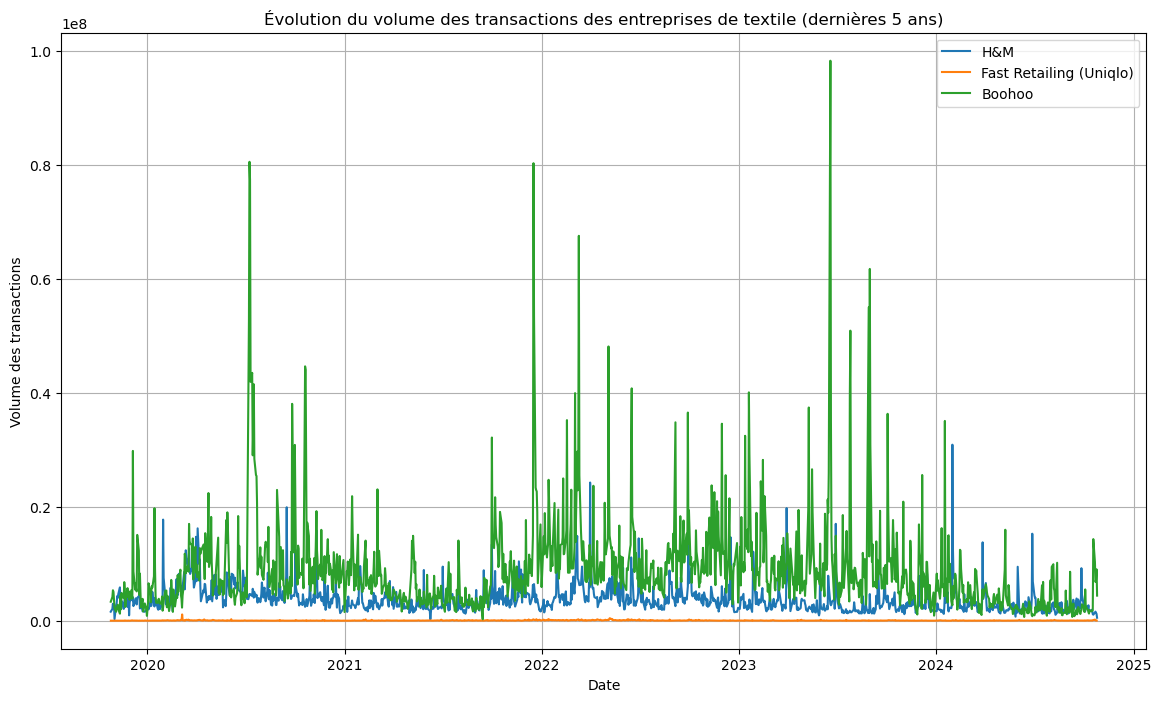

In [26]:
# Tracer l'évolution du volume des transactions par entreprise
plt.figure(figsize=(14, 8))
for entreprise in df['Entreprise'].unique():
    df_entreprise = df[df['Entreprise'] == entreprise]
    plt.plot(df_entreprise['Date'], df_entreprise['Volume'], label=entreprise)

# Ajouter des labels et une légende
plt.title("Évolution du volume des transactions des entreprises de textile (dernières 5 ans)")
plt.xlabel("Date")
plt.ylabel("Volume des transactions")
plt.legend()
plt.grid()
plt.show()

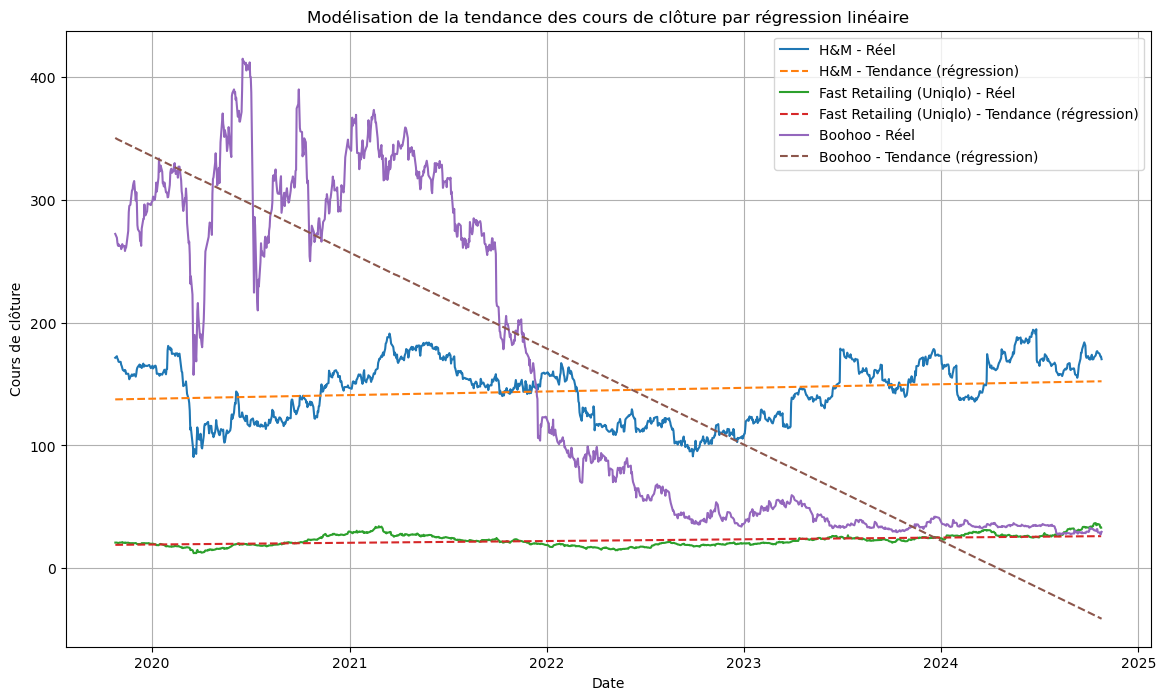

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Création du modèle de régression linéaire pour chaque entreprise
plt.figure(figsize=(14, 8))
for entreprise in df['Entreprise'].unique():
    df_entreprise = df[df['Entreprise'] == entreprise].copy()
    df_entreprise['DateOrdinal'] = df_entreprise['Date'].map(pd.Timestamp.toordinal)  # Convertir les dates en valeurs numériques

    # Préparer les données pour la régression
    X = df_entreprise['DateOrdinal'].values.reshape(-1, 1)
    y = df_entreprise['Clôture'].values

    # Créer et ajuster le modèle
    model = LinearRegression()
    model.fit(X, y)

    # Prédire les valeurs avec la régression linéaire
    y_pred = model.predict(X)

    # Tracer les cours de clôture et la tendance estimée
    plt.plot(df_entreprise['Date'], df_entreprise['Clôture'], label=f"{entreprise} - Réel")
    plt.plot(df_entreprise['Date'], y_pred, label=f"{entreprise} - Tendance (régression)", linestyle='--')

# Ajouter des labels et une légende
plt.title("Modélisation de la tendance des cours de clôture par régression linéaire")
plt.xlabel("Date")
plt.ylabel("Cours de clôture")
plt.legend()
plt.grid()
plt.show()

Tendance des cours via l'approche des Séries temporelles

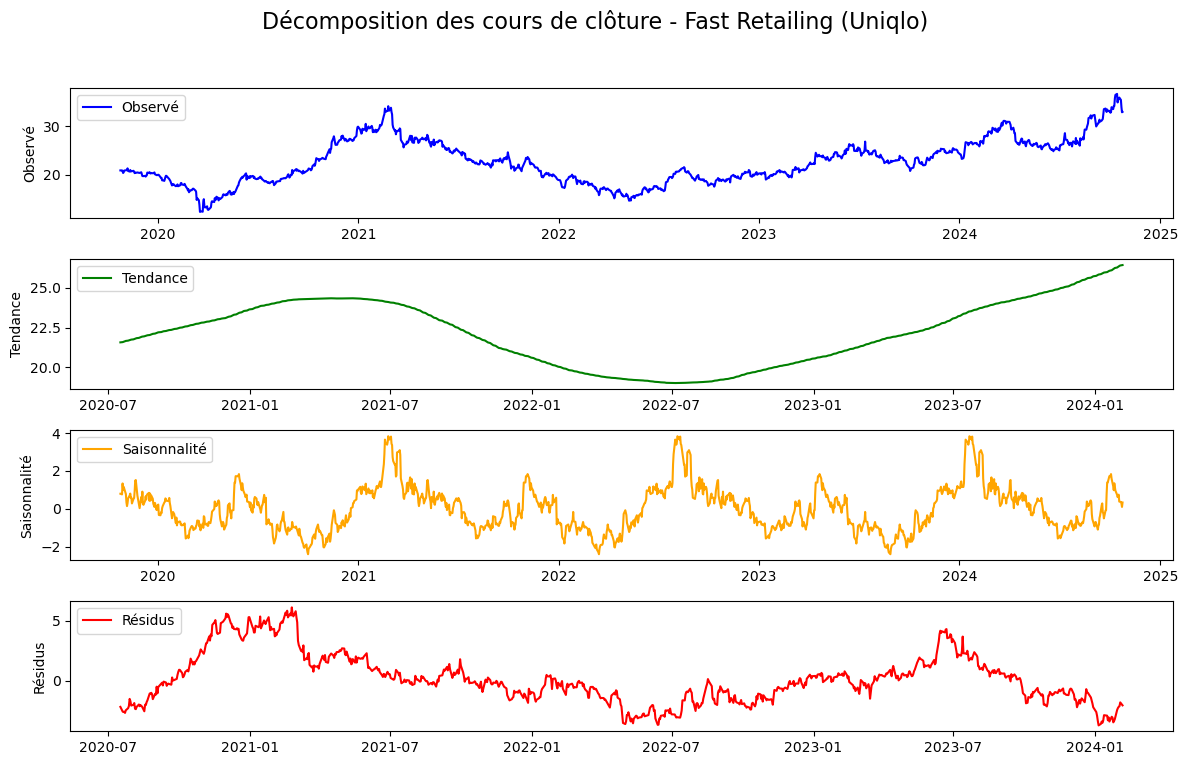

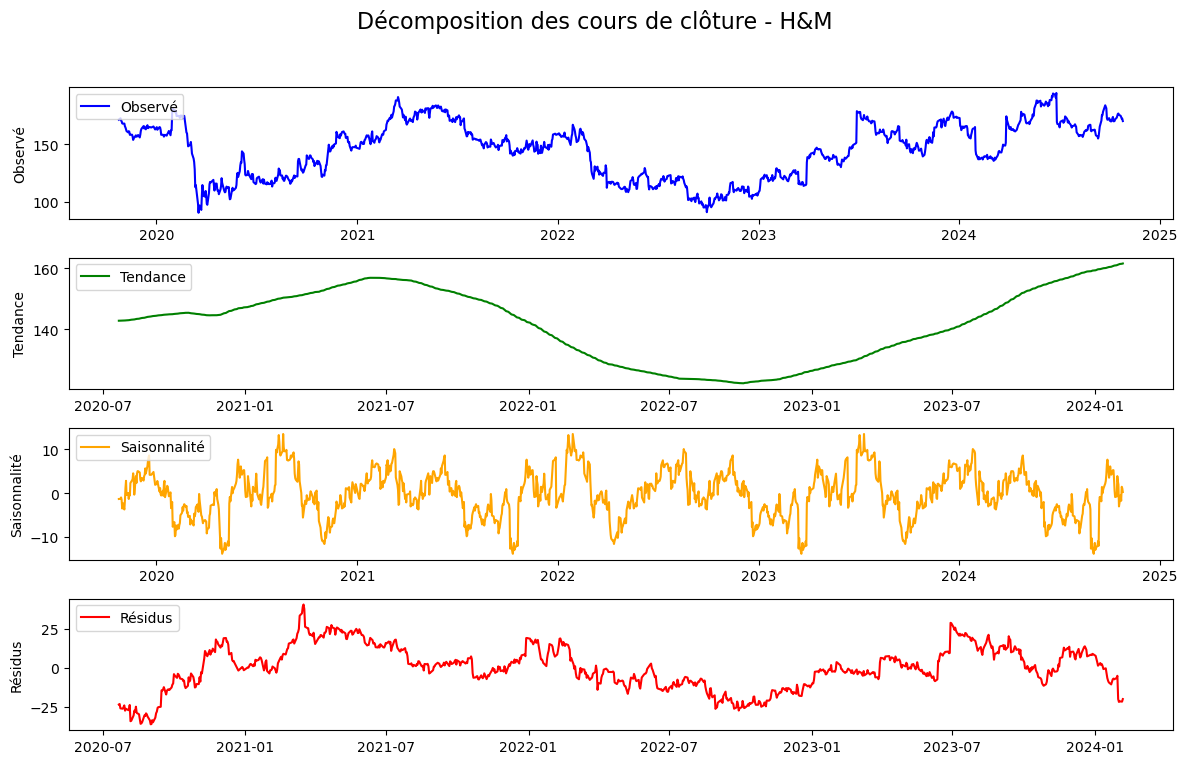

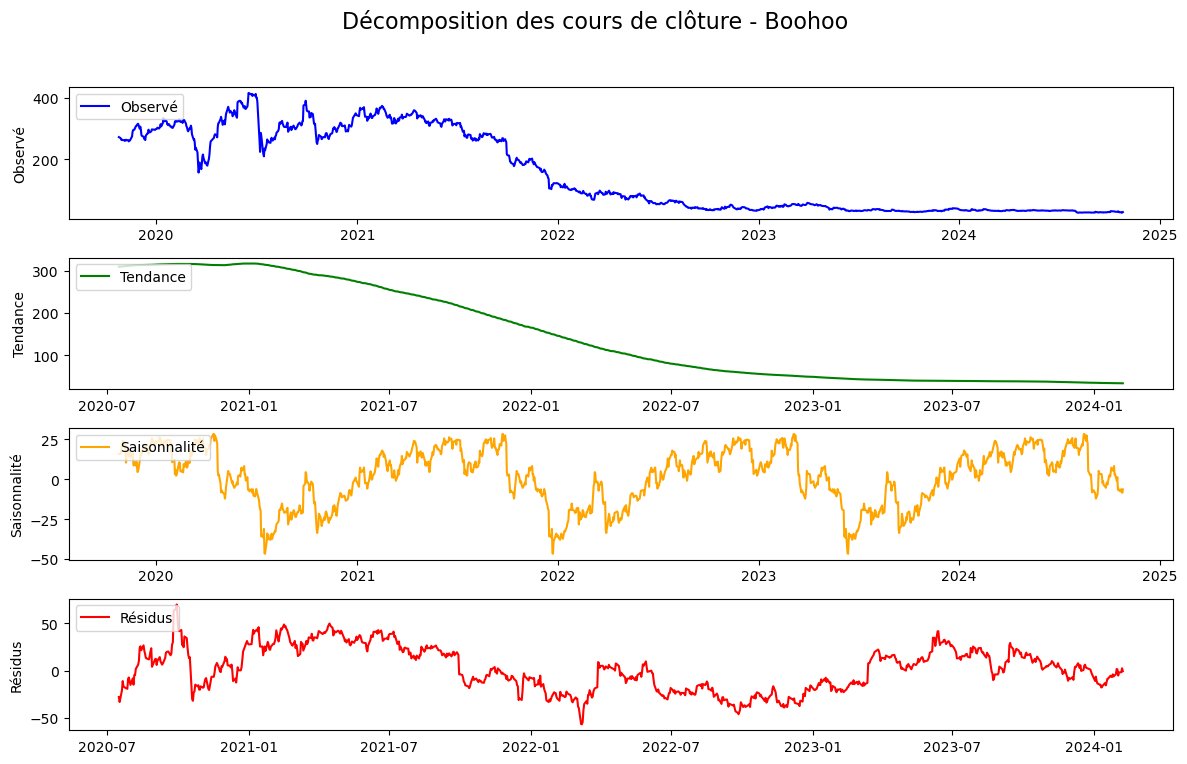

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convertir la colonne 'Date' au format datetime
df['Date'] = pd.to_datetime(df['Date'])

# Créer un index basé sur les dates pour faciliter l'analyse temporelle
df = df.set_index('Date')

# Entreprises à analyser
entreprises_analyse = ["Fast Retailing (Uniqlo)", "H&M", "Boohoo"]

# Parcourir chaque entreprise pour effectuer la décomposition
for entreprise in entreprises_analyse:
    # Filtrer les données pour l'entreprise courante
    df_entreprise = df[df['Entreprise'] == entreprise]

    # Effectuer la décomposition en série temporelle
    result = seasonal_decompose(df_entreprise['Clôture'], model='additive', period=365)

    # Tracer les composants de la série temporelle
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Décomposition des cours de clôture - {entreprise}", fontsize=16)

    # Tracer la série observée (Originale)
    plt.subplot(411)
    plt.plot(result.observed, label='Observé', color='blue')
    plt.legend(loc='upper left')
    plt.ylabel('Observé')

    # Tracer la composante de tendance (Trend)
    plt.subplot(412)
    plt.plot(result.trend, label='Tendance', color='green')
    plt.legend(loc='upper left')
    plt.ylabel('Tendance')

    # Tracer la composante de saisonnalité (Seasonal)
    plt.subplot(413)
    plt.plot(result.seasonal, label='Saisonnalité', color='orange')
    plt.legend(loc='upper left')
    plt.ylabel('Saisonnalité')

    # Tracer les résidus (Residual)
    plt.subplot(414)
    plt.plot(result.resid, label='Résidus', color='red')
    plt.legend(loc='upper left')
    plt.ylabel('Résidus')

    # Ajustement des espacements
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
